# Using Variational Autoencoder to Generate Faces

In this example, we are going to use VAE to generate faces. The dataset we are going to use is [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). The dataset consists of more than 200K celebrity face images. You have to download the Align&Cropped Images from the above website to run this example.

In [1]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.dataset import mnist
import datetime as dt
from bigdl.util.common import *
from glob import glob
import os
import scipy.misc
import numpy as np

from utils import *

image_size = 148
Z_DIM = 128
ENCODER_FILTER_NUM = 32

#download the data CelebA, and may repalce with your own data path
DATA_PATH = os.getenv("ANALYTICS_ZOO_HOME") + "/apps/variational-autoencoder/img_align_celeba"

init_engine()

## Define the Model

Here, we define a slightly more complicate CNN networks using convolution, batchnorm, and leakyRelu.

In [2]:
def conv_bn_lrelu(in_channels, out_channles, kw=4, kh=4, sw=2, sh=2, pw=-1, ph=-1):
    model = Sequential()
    model.add(SpatialConvolution(in_channels, out_channles, kw, kh, sw, sh, pw, ph))
    model.add(SpatialBatchNormalization(out_channles))
    model.add(LeakyReLU(0.2))
    return model

def upsample_conv_bn_lrelu(in_channels, out_channles, out_width, out_height, kw=3, kh=3, sw=1, sh=1, pw=-1, ph=-1):
    model = Sequential()
    model.add(ResizeBilinear(out_width, out_height))
    model.add(SpatialConvolution(in_channels, out_channles, kw, kh, sw, sh, pw, ph))
    model.add(SpatialBatchNormalization(out_channles))
    model.add(LeakyReLU(0.2))
    return model

In [3]:
def get_encoder_cnn():
    input0 = Input()
    
    #CONV
    conv1 = conv_bn_lrelu(3, ENCODER_FILTER_NUM)(input0) # 32 * 32 * 32
    conv2 = conv_bn_lrelu(ENCODER_FILTER_NUM, ENCODER_FILTER_NUM * 2)(conv1) # 16 * 16 * 64
    conv3 = conv_bn_lrelu(ENCODER_FILTER_NUM * 2, ENCODER_FILTER_NUM * 4)(conv2) # 8 * 8 * 128
    conv4 = conv_bn_lrelu(ENCODER_FILTER_NUM * 4, ENCODER_FILTER_NUM * 8)(conv3) # 4 * 4 * 256
    view = View([4*4*ENCODER_FILTER_NUM*8])(conv4)
    
    inter = Linear(4*4*ENCODER_FILTER_NUM*8, 2048)(view)
    inter = BatchNormalization(2048)(inter)
    inter = ReLU()(inter)
    
    # fully connected to generate mean and log-variance
    mean = Linear(2048, Z_DIM)(inter)
    
    log_variance = Linear(2048, Z_DIM)(inter)
    
    model = Model([input0], [mean, log_variance])
    return model

In [4]:
def get_decoder_cnn():
    input0 = Input()
    linear = Linear(Z_DIM, 2048)(input0)
    linear = Linear(2048, 4*4*ENCODER_FILTER_NUM * 8)(linear)
    reshape = Reshape([ENCODER_FILTER_NUM * 8, 4, 4])(linear)
    bn = SpatialBatchNormalization(ENCODER_FILTER_NUM * 8)(reshape)
    
    # upsampling
    up1 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM*8, ENCODER_FILTER_NUM*4, 8, 8)(bn) # 8 * 8 * 128
    up2 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM*4, ENCODER_FILTER_NUM*2, 16, 16)(up1) # 16 * 16 * 64
    up3 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM*2, ENCODER_FILTER_NUM, 32, 32)(up2) # 32 * 32 * 32
    up4 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM, 3, 64, 64)(up3) # 64 * 64 * 3
    output = Sigmoid()(up4)
    
    model = Model([input0], [output])
    return model

In [5]:
def get_autoencoder_cnn():
    input0 = Input()
    encoder = get_encoder_cnn()(input0)
    sampler = GaussianSampler()(encoder)
    
    decoder_model = get_decoder_cnn()
    decoder = decoder_model(sampler)
    
    model = Model([input0], [encoder, decoder])
    return model, decoder_model

In [6]:
model, decoder = get_autoencoder_cnn()

creating: createInput
creating: createInput
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createView
creating: createLinear
creating: createBatchNormalization
creating: createReLU
creating: createLinear
creating: createLinear
creating: createModel
creating: createGaussianSampler
creating: createInput
creating: createLinear
creating: createLinear
creating: createReshape
creating: createSpatialBatchNormalization
creating: createSequential
creating: createResizeBilinear
creating: createSpatialConvolution
creating:

## Load the Dataset

In [7]:
def get_data():
    data_files = glob(os.path.join(DATA_PATH, "*.jpg"))
    
    rdd_train_images = sc.parallelize(data_files[:100000]) \
                              .map(lambda path: inverse_transform(get_image(path, image_size)).transpose(2, 0, 1))
    rdd_train_sample = rdd_train_images.map(lambda img: Sample.from_ndarray(img, [np.array(0.0), img]))
    return rdd_train_sample

In [14]:
from pyspark import SparkContext 
sc =SparkContext.getOrCreate() 
train_data = get_data()



## Define the Training Objective

In [10]:
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 1.0) # You may want to twick this parameter
criterion.add(BCECriterion(size_average=False), 1.0 / 64)

creating: createParallelCriterion
creating: createKLDCriterion
creating: createBCECriterion


## Define the Optimizer

In [11]:
batch_size = 100


# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=criterion,
    optim_method=Adam(0.001, beta1=0.5),
    end_trigger=MaxEpoch(1),
    batch_size=batch_size)


app_name='vea-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/vae',
                                     app_name=app_name)

train_summary.set_summary_trigger("LearningRate", SeveralIteration(10))
train_summary.set_summary_trigger("Parameters", EveryEpoch())


optimizer.set_train_summary(train_summary)

print ("saving logs to ",app_name)

creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createTrainSummary
creating: createSeveralIteration
creating: createEveryEpoch
('saving logs to ', 'vea-20180514-113346')


## Spin Up the Training

This could take a while. It took about 2 hours on a desktop with a intel i7-6700 cpu and 40GB java heap memory. You can reduce the training time by using less data (some changes in the "Load the Dataset" section), but the performce may not as good.

In [12]:
redire_spark_logs()
show_bigdl_info_logs()

In [13]:
def gen_image_row():
    decoder.evaluate()
    return np.column_stack([decoder.forward(np.random.randn(1, Z_DIM)).reshape(3, 64,64).transpose(1, 2, 0) for s in range(8)])

def gen_image():
    return np.row_stack([gen_image_row() for i in range(8)])

In [ ]:
for i in range(1, 6):
    optimizer.set_end_when(MaxEpoch(i))
    trained_model = optimizer.optimize()
    image = gen_image()
    if not os.path.exists("./images"):
        os.makedirs("./images")
    if not os.path.exists("./models"):
        os.makedirs("./models")
    # you may change the following directory accordingly and make sure the directory
    # you are writing to exists
    scipy.misc.imsave("./images/image_%s.png" % i , image)
    decoder.saveModel("./models/decoder_%s.model" % i, over_write = True)

creating: createMaxEpoch


In [14]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


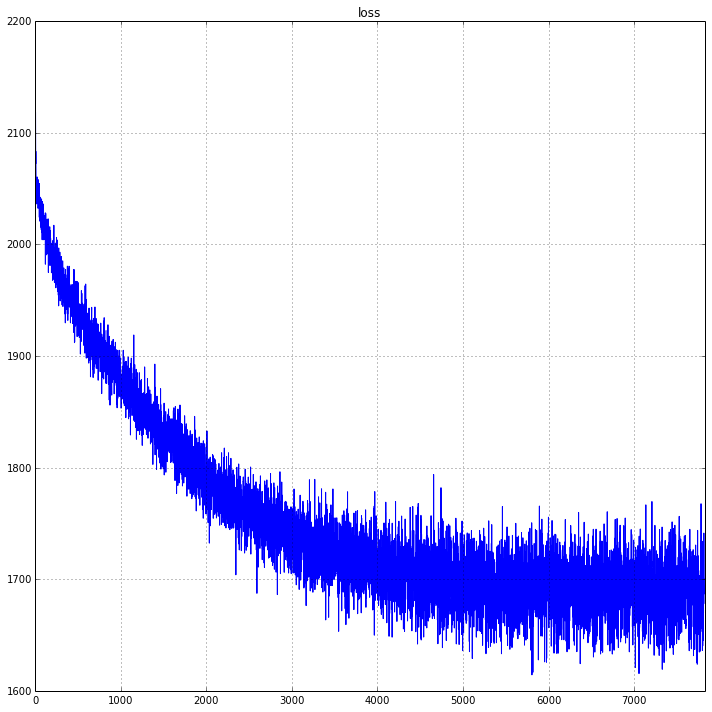

In [15]:
loss = np.array(train_summary.read_scalar("Loss"))

plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

## Random Sample Some Images

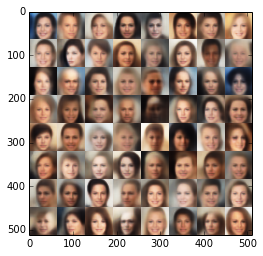

In [16]:
from matplotlib.pyplot import imshow
img = gen_image()
imshow(img)